# Quantum VaR Analysis: Impact of Kurtosis (Fat Tails)

## 1. Introduction
This notebook analyzes how the kurtosis (fat-tailedness) of return distributions affects Value at Risk (VaR). We use the Student's t-distribution, where lower Degrees of Freedom (df) imply fatter tails (higher kurtosis).
Gaussian distribution corresponds to $df \to \infty$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from classiq import *
from classiq.applications.iqae.iqae import IQAE

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
print("Environment initialized.")

Environment initialized.


## 2. Distribution Parameters & Discretization
We use `scipy.stats.t` (Student's t).
*   `df = 3`: Extreme fat tails (Crypto/Crisis-like).
*   `df = 10`: Moderate fat tails (Typical Equities).
*   `df = 100`: Normal-like distributions.

In [16]:
# Global Parameters
N = 128  # Grid points
num_qubits = int(np.log2(N))
ALPHA_VAR = 0.05  # 95% Confidence VaR
CALIBRATION_EPSILON = 0.01

# Market parameters (standardized for comparison)
mu = 0.15
sigma = 0.20

# Kurtosis parameters (Degrees of Freedom)
dof_params = [1, 5, 100]
labels = ['Fat Tails (df=3)', 'Moderate (df=10)', 'Gaussian-like (df=100)']
colors = ['#FF7F0E', '#2CA02C', '#1F77B4']

# Common grid (wider to capture fat tails)
grid_min = mu - 4 * sigma
grid_max = mu + 4 * sigma
grid_points = np.linspace(grid_min, grid_max, N)
dx = (grid_max - grid_min) / N

print(f"Grid range: [{grid_min:.3f}, {grid_max:.3f}] with {N} points.")
print(dx)

Grid range: [-0.650, 0.950] with 128 points.
0.0125


## 3. Discretize and Visualize Distributions
Note how `df=3` has much probability mass in the tails compared to `df=100`.

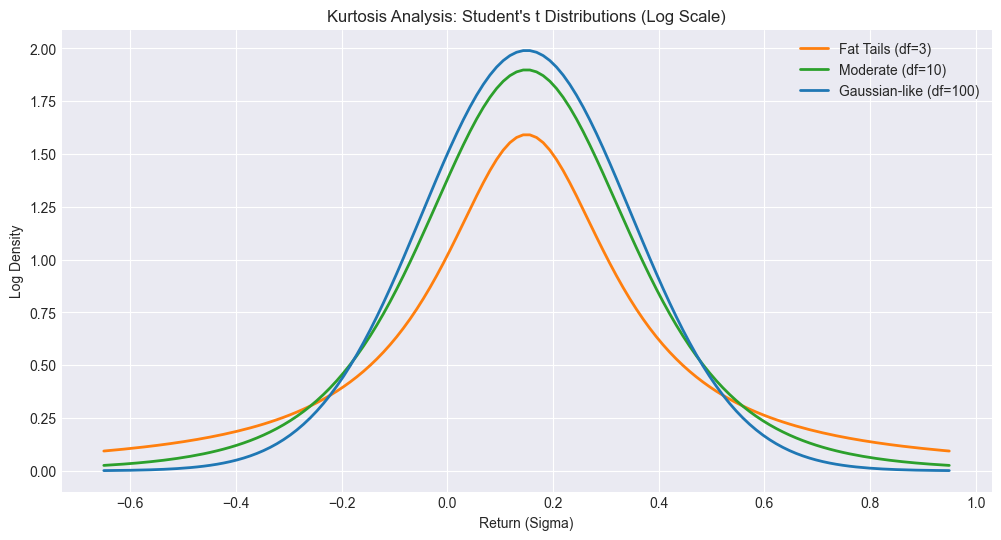

In [17]:
distributions_probs = []

plt.figure(figsize=(12, 6))

for df, label, c in zip(dof_params, labels, colors):
    # Generate pdf
    pdf_vals = stats.t.pdf(grid_points, df, loc=mu, scale=sigma)
    # Discretize
    probs = pdf_vals * dx
    probs /= np.sum(probs)  # Normalize
    distributions_probs.append(probs)
    
    plt.plot(grid_points, pdf_vals, label=f"{label}", color=c, lw=2)
    
    # Highlight tail area (approx)
    if df == 3:
        plt.fill_between(grid_points, 0, pdf_vals, color=c, alpha=0.1)

# plt.yscale('log') # Log scale to see tails better
# plt.ylim(0.001, 1.0)
plt.title("Kurtosis Analysis: Student's t Distributions (Log Scale)")
plt.xlabel("Return (Sigma)")
plt.ylabel("Log Density")
plt.legend()
plt.show()

## 4. Quantum VaR Estimation (IQAE)
Setup IQAE circuit.

In [18]:
# Shared Global for binding current probabilities and threshold
CURRENT_PROBS = []
THRESHOLD_IDX = 0

@qfunc
def load_fin_distribution(asset: QNum):
    inplace_prepare_state(CURRENT_PROBS, bound=0, target=asset)

@qperm
def payoff_oracle(asset: Const[QNum], ind: QBit):
    ind ^= asset < THRESHOLD_IDX

@qfunc(synthesize_separately=True)
def full_model(asset: QNum, ind: QBit):
    load_fin_distribution(asset)
    payoff_oracle(asset, ind)

def run_iqae_for_cdf(probs, threshold_index):
    global CURRENT_PROBS, THRESHOLD_IDX
    CURRENT_PROBS = list(probs)
    THRESHOLD_IDX = threshold_index
    
    iqae = IQAE(
        state_prep_op=full_model,
        problem_vars_size=num_qubits,
        constraints=Constraints(max_width=20),
    )
    
    # Run estimation
    result = iqae.run(epsilon=CALIBRATION_EPSILON, alpha=0.05)
    return result.estimation

## 5. VaR Search Routine

In [19]:
results = {}

print("Starting Quantum VaR Search (Kurtosis Analysis)...\n")

for i, (label, probs) in enumerate(zip(labels, distributions_probs)):
    print(f"--- Analyzing: {label} ---")
    
    # 1. Classical Approximation to seed
    cdf = np.cumsum(probs)
    approx_idx = np.searchsorted(cdf, ALPHA_VAR)
    
    # 2. Run IQAE
    q_cdf = run_iqae_for_cdf(probs, int(approx_idx))
    
    var_val = grid_points[approx_idx]
    results[label] = {'VaR_Return': var_val, 'CDF_Quantum': q_cdf}
    
    print(f"  > Approx Index: {approx_idx}")
    print(f"  > VaR (Threshold): {var_val:.4f}")
    print(f"  > Quantum CDF Est: {q_cdf:.4f}\n")

Starting Quantum VaR Search (Kurtosis Analysis)...

--- Analyzing: Fat Tails (df=3) ---
  > Approx Index: 23
  > VaR (Threshold): -0.3602
  > Quantum CDF Est: 0.0487

--- Analyzing: Moderate (df=10) ---
  > Approx Index: 33
  > VaR (Threshold): -0.2343
  > Quantum CDF Est: 0.0480

--- Analyzing: Gaussian-like (df=100) ---
  > Approx Index: 37
  > VaR (Threshold): -0.1839
  > Quantum CDF Est: 0.0448



## 6. Analysis
Fat-tailed distributions should show significantly higher (more negative) VaR than Gaussian-like ones.

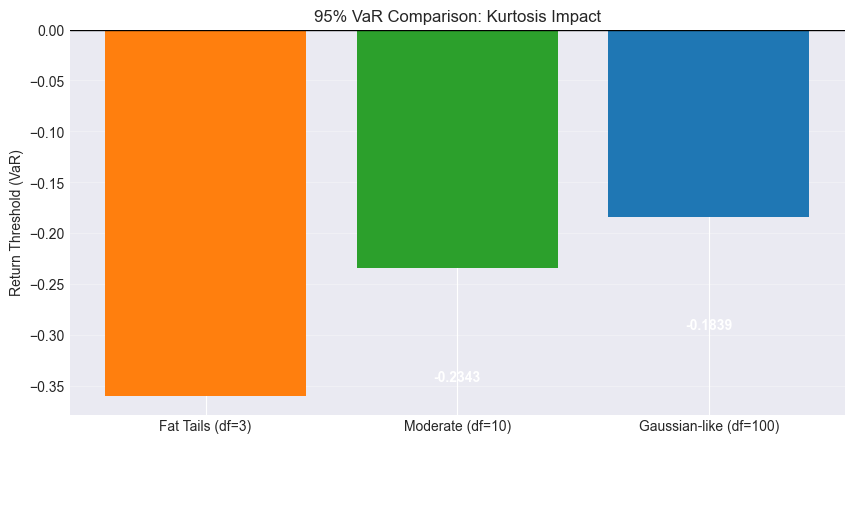

In [20]:
labels_res = list(results.keys())
var_vals = [results[k]['VaR_Return'] for k in labels_res]

plt.figure(figsize=(10, 5))
# Plot bars
bars = plt.bar(labels_res, var_vals, color=colors)
plt.axhline(0, color='black', lw=1)
plt.title("95% VaR Comparison: Kurtosis Impact")
plt.ylabel("Return Threshold (VaR)")

# Annotate
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 0.1, f"{yval:.4f}", 
             ha='center', va='top', color='white', fontweight='bold')

plt.grid(True, axis='y', alpha=0.3)
plt.show()